System information (for reproducibility):

In [33]:
versioninfo()

Julia Version 1.9.0
Commit 8e630552924 (2023-05-07 11:25 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin22.4.0)
  CPU: 12 × Apple M2 Max
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, apple-m1)
  Threads: 9 on 8 virtual cores
Environment:
  JULIA_NUM_THREADS = 8
  JULIA_EDITOR = code


Load packages:

In [34]:
using Pkg

Pkg.activate(pwd())
Pkg.instantiate()
Pkg.status()

  Activating project at `~/Documents/github.com/ucla-biostat-257/2023spring/slides/22-juliaopt`


Status `~/Documents/github.com/ucla-biostat-257/2023spring/slides/22-juliaopt/Project.toml`
  [1e616198] COSMO v0.8.7
  [13f3f980] CairoMakie v0.10.4
  [f65535da] Convex v0.15.3
  [31c24e10] Distributions v0.25.90
  [5789e2e9] FileIO v1.16.1
  [f6369f11] ForwardDiff v0.10.35
  [2e9cd046] Gurobi v1.0.1
  [b99e6be6] Hypatia v0.7.2
  [916415d5] Images v0.25.2
  [b6b21f68] Ipopt v1.2.1
  [4076af6c] JuMP v1.11.0
  [b8f27783] MathOptInterface v1.15.1
  [1ec41992] MosekTools v0.14.0
  [c946c3f1] SCS v1.1.4
  [276daf66] SpecialFunctions v2.2.0
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
  [2f01184e] SparseArrays
  [10745b16] Statistics v1.9.0


# Optimization in Julia

This lecture gives an overview of some optimization tools in Julia.

## Flowchart

* Statisticians do optimizations in daily life: maximum likelihood estimation, machine learning, ...

* Category of optimization problems:

    1. Problems with analytical solutions: least squares, principle component analysis, canonical correlation analysis, ...
    
    2. Problems subject to Disciplined Convex Programming (DCP): linear programming (LP), quadratic programming (QP), second-order cone programming (SOCP), semidefinite programming (SDP), and geometric programming (GP).
    
    3. Nonlinear programming (NLP): Newton type algorithms, Fisher scoring algorithm, EM algorithm, MM algorithms. 
    
    4. Large scale optimization: ADMM, SGD, ...
    
![Flowchart](./optimization_flowchart.png)

## Modeling tools and solvers

Getting familiar with **good** optimization softwares broadens the scope and scale of problems we are able to solve in statistics. Following table lists some of the best optimization softwares. 


|           |   | LP | MILP | SOCP |     MISOCP     | SDP | GP | NLP | MINLP |   | R | Matlab | Julia | Python |   | Cost |  
|:---------:|:-:|:--:|:----:|:----:|:--------------:|:---:|:--:|:---:|:-----:|:-:|:-:|:------:|:-----:|:------:|:-:|:----:|  
|   **modeling tools**   |   |    |      |      |                |     |    |     |       |   |   |        |       |        |   |      |  
|    cvx    |   |  x |   x  |   x  |        x       |  x  |  x |     |       |   | x |    x   |       |    x   |   |   A  |  
| Convex.jl |   |  x |   x  |   x  |        x       |  x  |    |     |       |   |   |        |   x   |        |   |   O  |  
|  JuMP.jl  |   |  x |   x  |   x  |        x       |     |    |  x  |   x   |   |   |        |   x   |        |   |   O  |  
| MathOptInterface.jl |   |  x |   x  |   x  |        x       |     |    |  x  |   x   |   |   |        |   x   |        |   |   O  |  
|   **convex solvers** |   |    |      |      |                |     |    |     |       |   |   |        |       |        |   |      |  
|   Mosek   |   |  x |   x  |   x  |        x       |  x  |  x |  x  |       |   | x |    x   |   x   |    x   |   |   A  |  
|   Gurobi  |   |  x |   x  |   x  |        x       |     |    |     |       |   | x |    x   |   x   |    x   |   |   A  |  
|   CPLEX   |   |  x |   x  |   x  |        x       |     |    |     |       |   | x |    x   |   x   |    x   |   |   A  |  
|    SCS    |   |  x |      |   x  |                |  x  |    |     |       |   |   |    x   |   x   |    x   |   |   O  |  
|    COSMO.jl    |  |  x |  |  x |              |  x  |    |     |       |   |   |     |   x   |     |   |   O  |  
|   **NLP solvers**  |   |    |      |      |                |     |    |     |       |   |   |        |       |        |   |      |  
|   NLopt   |   |  x |      |      |                |     |    |  x  |       |   | x |    x   |   x   |    x   |   |   O  |  
|   Ipopt   |   |  x |      |      |                |     |    |  x  |       |   | x |    x   |   x   |    x   |   |   O  |  
|   KNITRO  |   |  x |   x  |      |                |     |    |  x  |   x   |   | x |    x   |   x   |    x   |   |   $  |  

    O: open source, A: free academic license, $: commercial

* For more extended list of solvers, see [here](https://jump.dev/JuMP.jl/stable/installation/#Supported-solvers).

* Difference between **modeling tool** and **solvers**

    - **Modeling tools** such as cvx (for Matlab) and Convex.jl (Julia analog of cvx) implement the disciplined convex programming (DCP) paradigm proposed by Grant and Boyd (2008) <http://stanford.edu/~boyd/papers/disc_cvx_prog.html>. DCP prescribes a set of simple rules from which users can construct convex optimization problems easily.
    
    - **Solvers** (Mosek, Gurobi, Cplex, SCS, COSMO, Hypatia, ...) are concrete software implementation of optimization algorithms. My favorite ones are: Mosek/Gurobi/SCS for DCP and Ipopt/NLopt for nonlinear programming. Mosek and Gurobi are commercial software but free for academic use. SCS/Ipopt/NLopt are open source.  
    
    - Modeling tools usually have the capability to use a variety of solvers. But modeling tools are solver agnostic so users do not have to worry about specific solver interface.
    
* If you want to install the commercial solvers Gurobi or Mosek, instructions are below:
    - Gurobi: 1. Download Gurobi at [link](http://www.gurobi.com/downloads/gurobi-optimizer). 2. Request free academic license at [link](https://www.gurobi.com/academia/academic-program-and-licenses/). 3. Run `grbgetkey XXXXXXXXX` command on terminal as suggested. It'll retrieve a license file and put it under the home folder. 4. Set up the environmental variables. On my machine, I put following two lines in the `~/.julia/config/startup.jl` file: `ENV["GUROBI_HOME"] = "/Library/gurobi902/mac64"` and `ENV["GRB_LICENSE_FILE"] = "/Users/huazhou/Documents/Gurobi/gurobi.lic"`.  
    - Mosek: 1. Request free academic license at [link](https://www.mosek.com/products/academic-licenses/). The license file will be sent to your edu email within minutes. Check Spam folder if necessary. 2. Put the license file at the default location `~/mosek/`.
    - Convex.jl, SCS.jl, Gurobi.jl, Mosek.jl, MathProgBase.jl, NLopt.jl, Ipopt.jl.

## DCP Using Convex.jl

Standard convex problem classes like LP (linear programming), QP (quadratic programming), SOCP (second-order cone programming), SDP (semidefinite programming), and GP (geometric programming), are becoming a **technology**.

![DCP Hierarchy](./convex-hierarchy.png)

### Example: microbiome regression analysis

We illustrate optimization tools in Julia using microbiome analysis as an example.

16S microbiome sequencing techonology generates sequence counts of various organisms (OTUs, operational taxonomic units) in samples. 

![Microbiome Data](./microbiome_data.png)

For statistical analysis, counts are normalized into **proportions** for each sample, resulting in a covariate matrix $\mathbf{X}$ with all rows summing to 1. For identifiability, we need to add a sum-to-zero constraint to the regression cofficients. In other words, we need to solve a **constrained least squares problem**  
$$
    \text{minimize} \frac{1}{2} \|\mathbf{y} - \mathbf{X} \beta\|_2^2
$$
subject to the constraint $\sum_{j=1}^p \beta_j = 0$. For simplicity we ignore intercept and non-OTU covariates in this presentation.

Let's first generate an artifical data set.

In [35]:
using Random, LinearAlgebra, SparseArrays

Random.seed!(257) # seed

n, p = 100, 50
X = rand(n, p)
# scale each row of X sum to 1
lmul!(Diagonal(1 ./ vec(sum(X, dims=2))), X)
# true β is a sparse vector with about 10% non-zero entries
β = sprandn(p, 0.1) 
y = X * β + randn(n);

### Sum-to-zero regression

The sum-to-zero contrained least squares is a standard quadratic programming (QP) problem so should be solved easily by any QP solver.

#### Modeling using Convex.jl

We use the Convex.jl package to model this QP problem. For a complete list of operations supported by Convex.jl, see <http://www.juliaopt.org/Convex.jl/stable/operations/>.

In [36]:
using Convex

β̂cls = Variable(size(X, 2))
problem = minimize(0.5sumsquares(y - X * β̂cls)) # objective
problem.constraints += sum(β̂cls) == 0; # constraint
problem

minimize
└─ * (convex; positive)
   ├─ 0.5
   └─ qol_elem (convex; positive)
      ├─ norm2 (convex; positive)
      │  └─ …
      └─ [1.0;;]
subject to
└─ == constraint (affine)
   ├─ sum (affine; real)
   │  └─ 50-element real variable (id: 160…215)
   └─ 0

status: `solve!` not called yet

#### Mosek

We first use the Mosek solver to solve this QP.

In [37]:
using MosekTools, MathOptInterface
const MOI = MathOptInterface

#solver = Model(optimizer_with_attributes(Mosek.Optimizer, "LOG" => 1))
solver = Mosek.Optimizer()
MOI.set(solver, MOI.RawOptimizerAttribute("LOG"), 1)

@time solve!(problem, solver)

Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3               
  Affine conic cons.     : 2               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 53              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Obj

In [38]:
# Check the status, optimal value, and minimizer of the problem
problem.status, problem.optval, β̂cls.value

(MathOptInterface.OPTIMAL, 28.846723057519807, [5.509993075106806; 2.38356718314364; … ; -3.5233708674877446; -14.863428486209692;;])

In [39]:
# check constraint satisfication
sum(β̂cls.value)

-5.353228971216595e-11

#### Gurobi

Switch to Gurobi solver:

In [40]:
using Gurobi

solver = Gurobi.Optimizer()
MOI.set(solver, MOI.RawOptimizerAttribute("OutputFlag"), 1)

@time solve!(problem, solver)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-16
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 107 rows, 157 columns and 5160 nonzeros
Model fingerprint: 0x0b8f1245
Model has 2 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-05, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 3e+00]
Presolve removed 2 rows and 1 columns
Presolve time: 0.00s
Presolved: 105 rows, 156 columns, 5158 nonzeros
Presolved model has 2 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 50
 AA' NZ     : 5.154e+03
 Factor NZ  : 5.262e+03
 Factor Ops : 3.590e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          D

In [41]:
# Check the status, optimal value, and minimizer of the problem
problem.status, problem.optval, β̂cls.value

(MathOptInterface.OPTIMAL, 28.846723593774414, [5.509988674912982; 2.383570183028111; … ; -3.52336924132222; -14.863438065647722;;])

In [42]:
# check constraint satisfication
sum(β̂cls.value)

-7.105427357601002e-15

#### COSMO

Switch to COSMO solver (pure Julia implementation):

In [43]:
# Use COSMO solver
using COSMO

solver = COSMO.Optimizer()
MOI.set(solver, MOI.RawOptimizerAttribute("max_iter"), 5000)

@time solve!(problem, solver)

------------------------------------------------------------------
          COSMO v0.8.7 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2022
------------------------------------------------------------------

Problem:  x ∈ R^{53},
          constraints: A ∈ R^{107x53} (5056 nnz),
          matrix size to factor: 160x160,
          Floating-point precision: Float64
Sets:     SecondOrderCone of dim: 101
          SecondOrderCone of dim: 3
          ZeroSet of dim: 2
          Nonnegatives of dim: 1
Settings: ϵ_abs = 1.0e-05, ϵ_rel = 1.0e-05,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 5000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Acc:      Anderson Type2{QRDecomp},
          Memory size = 15, RestartedMemory,	
          Safeguar

In [44]:
# Check the status, optimal value, and minimizer of the problem
problem.status, problem.optval, β̂cls.value

(MathOptInterface.OPTIMAL, 28.84654903634894, [5.509991414306472; 2.3835690859317555; … ; -3.5233705424761044; -14.863434599228132;;])

We see COSMO have a looser criterion for constraint satisfication, resulting a lower objective value.

In [45]:
sum(β̂cls.value)

6.120813509369327e-7

#### SCS

Switch to the open source SCS solver:

In [46]:
# Use SCS solver
using SCS

solver = SCS.Optimizer()
MOI.set(solver, MOI.RawOptimizerAttribute("verbose"), 1)

@time solve!(problem, solver)

  0.404455 seconds (1.15 M allocations: 79.914 MiB, 99.00% compilation time: 96% of which was recompilation)
------------------------------------------------------------------
	       SCS v3.2.3 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 53, constraints m: 107
cones: 	  z: primal zero / dual free vars: 2
	  l: linear vars: 1
	  q: soc vars: 104, qsize: 2
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 5056, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 1.10e+01  6.36e+00  5.33e

In [47]:
# Check the status, optimal value, and minimizer of the problem
problem.status, problem.optval, β̂cls.value

(MathOptInterface.OPTIMAL, 28.846742781881755, [5.509993089336321; 2.3835671895274055; … ; -3.523370875539148; -14.86342852285362;;])

In [48]:
# check constraint satisfication
sum(β̂cls.value)

-6.829523613305355e-10

#### Hypatia

Switch to the open source Hypatia (pure Julia) solver:

In [49]:
# Use Hypatia solver
using Hypatia

solver = Hypatia.Optimizer()
MOI.set(solver, MOI.RawOptimizerAttribute("verbose"), 1)

@time solve!(problem, solver)


 iter        p_obj        d_obj |  abs_gap    x_feas    z_feas |      tau       kap        mu | dir_res     prox  step     alpha
    0   5.0000e-01  -2.0000e+00 | 5.00e+00  3.12e-01  5.59e-01 | 1.00e+00  1.00e+00  1.00e+00 |
    1   2.4639e+00   4.0538e+00 | 7.25e-01  2.28e-01  4.09e-01 | 2.05e-01  8.51e-01  1.50e-01 | 4.9e-15  7.1e-01  co-a  8.50e-01
    2   7.3406e+00   1.3360e+01 | 2.05e-01  1.80e-01  3.22e-01 | 7.82e-02  6.28e-01  4.23e-02 | 1.5e-15  7.3e-01  co-a  7.00e-01
    3   1.5237e+01   2.1114e+01 | 7.36e-02  1.10e-01  1.98e-01 | 5.08e-02  3.62e-01  1.53e-02 | 5.6e-15  6.9e-01  co-a  6.00e-01
    4   2.6789e+01   2.8307e+01 | 9.80e-03  2.18e-02  3.90e-02 | 3.87e-02  6.83e-02  2.07e-03 | 4.2e-15  9.0e-01  co-a  8.50e-01
    5   2.8750e+01   2.8796e+01 | 2.64e-04  7.03e-04  1.26e-03 | 3.60e-02  1.93e-03  5.56e-05 | 1.4e-15  5.2e-01  co-a  9.70e-01
    6   2.8842e+01   2.8844e+01 | 2.95e-05  6.90e-05  1.24e-04 | 3.67e-02  1.26e-04  5.68e-06 | 2.7e-13  9.0e-01  co-a  9.00e-01


In [50]:
# Check the status, optimal value, and minimizer of the problem
problem.status, problem.optval, β̂cls.value

(MathOptInterface.OPTIMAL, 28.846722779300734, [5.509993060995226; 2.383567193189857; … ; -3.5233708315070373; -14.863428534457675;;])

In [51]:
# check constraint satisfication
sum(β̂cls.value)

-2.842170943040401e-14

### Sum-to-zero lasso

Suppose we want to know which organisms (OTU) are associated with the response. We can answer this question using a sum-to-zero contrained lasso
$$
    \text{minimize} \frac 12 \|\mathbf{y} - \mathbf{X} \beta\|_2^2 + \lambda \|\beta\|_1
$$
subject to the constraint $\sum_{j=1}^p \beta_j = 0$. Varying $\lambda$ from small to large values will generate a solution path.

In [52]:
using Convex

# # Use Mosek solver
# using Mosek
# solver = Mosek.Optimizer()
# MOI.set(solver, MOI.RawOptimizerAttribute("LOG"), 0)

# # Use Gurobi solver
# using Gurobi
# solver = Gurobi.Optimizer(OutputFlag=0)

# Use Cplex solver
# using CPLEX
# solver = CplexSolver(CPXPARAM_ScreenOutput=0)

# # Use SCS solver
# using SCS
# solver = SCS.Optimizer(verbose=0)

# Use Hypatia solver
using Hypatia
solver = Hypatia.Optimizer()

# solve at a grid of λ
λgrid = 0:0.01:0.35

# holder for solution path
β̂path = zeros(length(λgrid), size(X, 2)) # each row is β̂ at a λ
# optimization variable
β̂classo = Variable(size(X, 2))
# obtain solution path using warm start
@time for i in 1:length(λgrid)
    λ = λgrid[i]
    # define optimization problem
    # objective
    problem = minimize(0.5sumsquares(y - X * β̂classo) + λ * sum(abs, β̂classo))
    # constraint
    problem.constraints += sum(β̂classo) == 0 # constraint
    solver = Mosek.Optimizer()
    MOI.set(solver, MOI.RawOptimizerAttribute("LOG"), 0)
    solve!(problem, solver)
    β̂path[i, :] = β̂classo.value
end

  0.196382 seconds (1.60 M allocations: 156.354 MiB, 10.36% gc time)


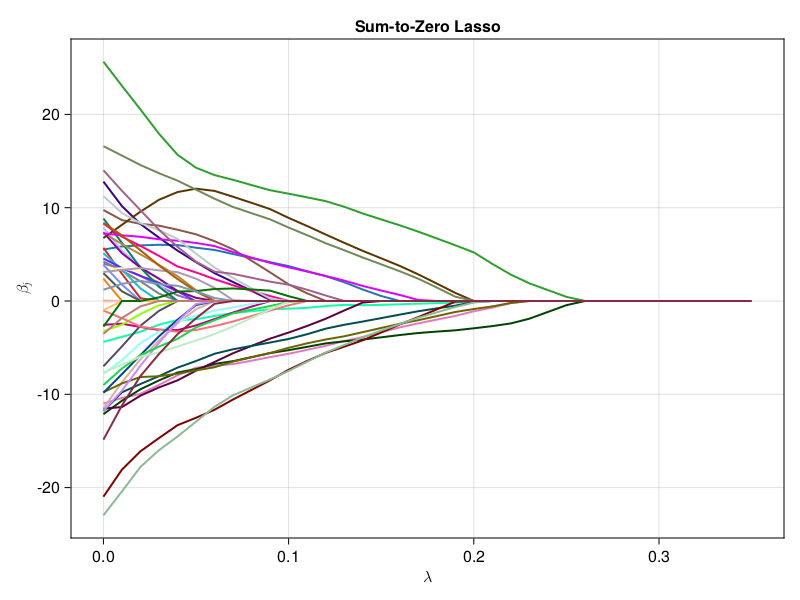

In [53]:
using CairoMakie

f = Figure()
Axis(
    f[1, 1], 
    title = "Sum-to-Zero Lasso",
    xlabel = L"\lambda",
    ylabel = L"\beta_j"
)
series!(λgrid, β̂path', color = :glasbey_category10_n256)
f

### Sum-to-zero group lasso

Suppose we want to do variable selection not at the OTU level, but at the Phylum level. OTUs are clustered into various Phyla. We can answer this question using a sum-to-zero contrained group lasso
$$
    \text{minimize} \frac 12 \|\mathbf{y} - \mathbf{X} \beta\|_2^2 + \lambda \sum_j \|\mathbf{\beta}_j\|_2
$$
subject to the constraint $\sum_{j=1}^p \beta_j = 0$, where $\mathbf{\beta}_j$ are regression coefficients corresponding to the $j$-th phylum. This is a second-order cone programming (SOCP) problem readily modeled by Convex.jl.

Let's assume each 10 contiguous OTUs belong to one Phylum.

In [54]:
# # Use Mosek solver
# using MosekTools

# # Use Gurobi solver
# using Gurobi

# # Use Cplex solver
# using CPLEX
# solver = CplexSolver(CPXPARAM_ScreenOutput=0)

# # Use SCS solver
# using SCS
# solver = SCSSolver(verbose=0)

# Use Hypatia solver
using Hypatia
solver = Hypatia.Optimizer()

# solve at a grid of λ
λgrid = 0.0:0.005:0.5
β̂pathgrp = zeros(length(λgrid), size(X, 2)) # each row is β̂ at a λ
β̂classo = Variable(size(X, 2))
@time for i in 1:length(λgrid)
    λ = λgrid[i]
    # loss
    obj = 0.5sumsquares(y - X * β̂classo)
    # group lasso penalty term
    for j in 1:(size(X, 2)/10)
        βj = β̂classo[(10(j-1)+1):10j]
        obj = obj + λ * norm(βj)
    end
    problem = minimize(obj)
    # constraint
    problem.constraints += sum(β̂classo) == 0 # constraint
    solver = Mosek.Optimizer()
    MOI.set(solver, MOI.RawOptimizerAttribute("LOG"), 0)
    solve!(problem, solver)
    β̂pathgrp[i, :] = β̂classo.value
end

  0.356510 seconds (735.37 k allocations: 196.149 MiB, 10.95% gc time)


We see it took Mosek <2 second to solve this seemingly hard optimization problem at **101** different $\lambda$ values.

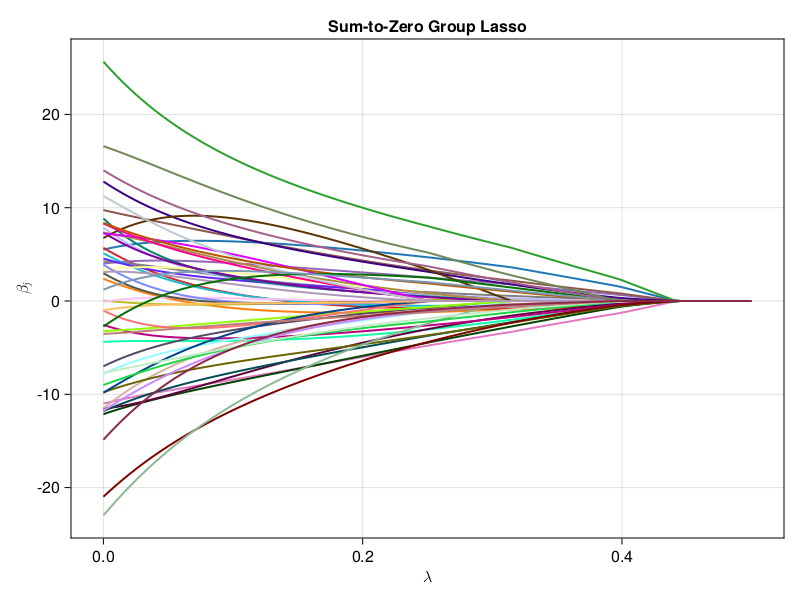

In [55]:
using CairoMakie

f = Figure()
Axis(
    f[1, 1], 
    title = "Sum-to-Zero Group Lasso",
    xlabel = L"\lambda",
    ylabel = L"\beta_j"
)
series!(λgrid, β̂pathgrp', color = :glasbey_category10_n256)
f

### Example: matrix completion

Load the $128 \times 128$ Lena picture with missing pixels.

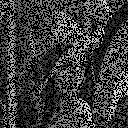

In [56]:
using FileIO

lena = load("lena128missing.png")

In [57]:
# convert to real matrices
Y = Float64.(lena)

128×128 Matrix{Float64}:
 0.0       0.0       0.635294  0.0       …  0.0       0.0       0.627451
 0.627451  0.623529  0.0       0.611765     0.0       0.0       0.388235
 0.611765  0.611765  0.0       0.0          0.403922  0.219608  0.0
 0.0       0.0       0.611765  0.0          0.223529  0.176471  0.192157
 0.611765  0.0       0.615686  0.615686     0.0       0.0       0.0
 0.0       0.0       0.0       0.619608  …  0.0       0.0       0.2
 0.607843  0.0       0.623529  0.0          0.176471  0.192157  0.0
 0.0       0.0       0.623529  0.0          0.0       0.0       0.215686
 0.619608  0.619608  0.0       0.0          0.2       0.0       0.207843
 0.0       0.0       0.635294  0.635294     0.2       0.192157  0.188235
 0.635294  0.0       0.0       0.0       …  0.192157  0.180392  0.0
 0.631373  0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.627451  0.635294  0.666667     0.172549  0.0       0.184314
 ⋮                                       ⋱  ⋮           

We fill out the missin pixels uisng a **matrix completion** technique developed by Candes and Tao
$$
    \text{minimize } \|\mathbf{X}\|_*
$$
$$
    \text{subject to } x_{ij} = y_{ij} \text{ for all observed entries } (i, j).
$$
Here $\|\mathbf{M}\|_* = \sum_i \sigma_i(\mathbf{M})$ is the nuclear norm. In words we seek the matrix with minimal nuclear norm that agrees with the observed entries. This is a semidefinite programming (SDP) problem readily modeled by Convex.jl.

This example takes longer because of high dimensionality. COSMO.jl seems to be the fastest solver for this problem. Other solvers take excessively long time.

In [58]:
# # Use COSMO solver
using COSMO
solver = COSMO.Optimizer()

# # Use Hypatia solver
# using Hypatia
# solver = Hypatia.Optimizer()

# Linear indices of obs. entries
obsidx = findall(Y[:] .≠ 0.0)
# Create optimization variables
X = Variable(size(Y))
# Set up optmization problem
problem = minimize(nuclearnorm(X))
problem.constraints += X[obsidx] == Y[obsidx]
# Solve the problem by calling solve
@time solve!(problem, solver) # fast

------------------------------------------------------------------
          COSMO v0.8.7 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2022
------------------------------------------------------------------

Problem:  x ∈ R^{49153},
          constraints: A ∈ R^{73665x49153} (73793 nnz),
          matrix size to factor: 122818x122818,
          Floating-point precision: Float64
Sets:     ZeroSet of dim: 40769
          DensePsdConeTriangle of dim: 32896 (256x256)
Settings: ϵ_abs = 1.0e-05, ϵ_rel = 1.0e-05,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 5000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Acc:      Anderson Type2{QRDecomp},
          Memory size = 15, RestartedMemory,	
          Safeguarded: true, tol: 2.0
Setup Time: 1

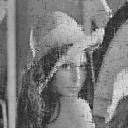

In [59]:
using Images

#Gray.(X.value)
colorview(Gray, X.value)

## Nonlinear programming (NLP)

We use MLE of Gamma distribution to illustrate some rudiments of nonlinear programming (NLP) in Julia. 

Let $x_1,\ldots,x_m$ be a random sample from the gamma density
$$
f(x) = \Gamma(\alpha)^{-1} \beta^{\alpha} x^{\alpha-1} e^{-\beta x}
$$
on $(0,\infty)$. The loglikelihood function is
$$
    L(\alpha, \beta) = m [- \ln \Gamma(\alpha) + \alpha \ln \beta + (\alpha - 1)\overline{\ln x} - \beta \bar x],
$$
where $\overline{x} = \frac{1}{m} \sum_{i=1}^m x_i$ and 
$\overline{\ln x} = \frac{1}{m} \sum_{i=1}^m \ln x_i$.

In [60]:
using Random, Statistics, SpecialFunctions

Random.seed!(123)

function gamma_logpdf(x::Vector, α::Real, β::Real)
    m = length(x)
    avg = mean(x)
    logavg = sum(log, x) / m
    m * (- log(gamma(α)) + α * log(β) + (α - 1) * logavg - β * avg)
end

x = rand(5)
gamma_logpdf(x, 1.0, 1.0)

-2.7154683416493226

Many optimization algorithms involve taking derivatives of the objective function. The `ForwardDiff.jl` package implements automatic differentiation. For example, to compute the derivative and Hessian of the log-likelihood with data `x` at `α=1.0` and `β=1.0`.

In [61]:
using ForwardDiff

ForwardDiff.gradient(θ -> gamma_logpdf(x, θ...), [1.0; 1.0])

2-element Vector{Float64}:
 -0.7131899304276518
  2.2845316583506774

In [62]:
ForwardDiff.hessian(θ -> gamma_logpdf(x, θ...), [1.0; 1.0])

2×2 Matrix{Float64}:
 -8.22467   5.0
  5.0      -5.0

Generate data:

In [63]:
using Distributions, Random

Random.seed!(123)
(n, p) = (1000, 2)
(α, β) = 5.0 * rand(p)
x = rand(Gamma(α, β), n)
println("True parameter values:")
println("α = ", α, ", β = ", β)

True parameter values:
α = 2.606068977676915, β = 2.934033787266742


We use JuMP.jl to define and solve our NLP problem.

In [64]:
using JuMP

# using NLopt
# m = Model(NLopt.Optimizer)
# set_optimizer_attribute(m, "algorithm", :LD_MMA)

using Ipopt
m = Model(Ipopt.Optimizer)
set_optimizer_attribute(m, "print_level", 3)

myf(a, b) = gamma_logpdf(x, a, b)
JuMP.register(m, :myf, 2, myf, autodiff=true)
@variable(m, α >= 1e-8)
@variable(m, β >= 1e-8)
@NLobjective(m, Max, myf(α, β))

print(m)
status = JuMP.optimize!(m)

println("MLE (JuMP):")
println("α = ", α, ", β = ", β)
println("Objective value: ", JuMP.objective_value(m))
println("α = ", JuMP.value(α), ", β = ", 1 / JuMP.value(β))
println("MLE (Distribution package):")
println(fit_mle(Gamma, x))

Total number of variables............................:        2
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............:   2.8242686979100025e-05   -2.8242686979100026e+03
Dual infeasibility......:   2.0271409244855300e-09    2.0271409244855301e-01
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementari